In [1]:
!pip install pyreadstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 23.5 MB/s eta 0:00:00


In [2]:
!pip install rdrobust

In [3]:
!pip install linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.3 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pyreadstat
from statsmodels.sandbox.regression.gmm import IV2SLS
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
from linearmodels.iv import IV2SLS, compare
from linearmodels.shared.hypotheses import WaldTestStatistic as wald_test
from rdrobust import rdplot, rdbwselect, rdrobust
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols


Задача 1 про сигареты и вес ребенка.

In [5]:
file = "bwght.dta"
df, meta = pyreadstat.read_dta(file)
df.fillna(0, inplace=True) # замена пропусков на нули, чтобы дальше не было ошибок
df

<ipython-input-5-785201dfb273>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


,faminc,cigtax,cigprice,bwght,fatheduc,motheduc,parity,male,white,cigs,lbwght,bwghtlbs,packs,lfaminc
0,13.5,16.5,122.300003,109,12,12,1,1,1,0,4.691348,6.8125,0.0,2.602690
1,7.5,16.5,122.300003,133,6,12,2,1,0,0,4.890349,8.3125,0.0,2.014903
2,0.5,16.5,122.300003,129,0,12,2,0,0,0,4.859812,8.0625,0.0,-0.693147
3,15.5,16.5,122.300003,126,12,12,2,1,0,0,4.836282,7.8750,0.0,2.740840
4,27.5,16.5,122.300003,134,14,12,2,1,1,0,4.897840,8.3750,0.0,3.314186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1383,27.5,30.0,138.300003,110,12,12,4,1,1,0,4.700480,6.8750,0.0,3.314186
1384,5.5,30.0,138.300003,146,0,16,2,1,1,0,4.983607,9.1250,0.0,1.704748
1385,65.0,8.0,118.599998,135,18,16,2,0,1,0,4.905275,8.4375,0.0,4.174387
1386,27.5,8.0,118.599998,118,0,14,2,0,1,0,4.770685,7.3750,0.0,3.314186


пункт с)

In [6]:
# зависимая переменная: lbwght (логарифм веса новорожденного)
# независимые переменные: male, parity, lfaminc, cigs
X_ols = df[['male', 'parity', 'lfaminc', 'cigs']]
X_ols = sm.add_constant(X_ols)
y = df['lbwght']
ml_ols = sm.OLS(y, X_ols).fit()

ml_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lbwght   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     12.55
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           4.90e-10
Time:                        11:27:56   Log-Likelihood:                 356.03
No. Observations:                1388   AIC:                            -702.1
Df Residuals:                    1383   BIC:                            -675.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6756      0.022    213.681      0.000       4.633       4.719
male           0.0262      0.010      2.601      0.009       0.006       0.046
parity         0.0147      0.006      2.600      0.009       0.004       0.026
lfaminc        0.0180      0.006      3.233      0.001       0.007       0.029
cigs          -0.0042      0.001     -4.890      0.000      -0.006      -0.003
==============================================================================
Omnibus:                      614.841   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6025.606
Skew:                          -1.799   Prob(JB):                         0.00
Kurtosis:                      12.552   Cond. No.                         29.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
# коэффициенты модели
coefficients = ml_ols.params

# уравнение модели
equation = f"lbwght = {coefficients[0]:.4f} + {coefficients[1]:.4f} * male + {coefficients[2]:.4f} * parity + {coefficients[3]:.4f} * lfaminc  + {coefficients[4]:.4f} * cigs"

#  коэффициенты в виде таблицы
coefficients_df = pd.DataFrame(coefficients, columns=['Coefficient'])
equation

<ipython-input-7-c350d333783c>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


'lbwght = 4.6756 + 0.0262 * male + 0.0147 * parity + 0.0180 * lfaminc  + -0.0042 * cigs'

In [8]:
coefficients_df

,Coefficient
const,4.675618
male,0.026241
parity,0.014729
lfaminc,0.018050
cigs,-0.004186


пункт д) метод 2МНК - взято и адаптировно с семинара
использование встроенных функций из питона

In [9]:
df['const'] = np.ones_like(df['lbwght'])

iv = IV2SLS(dependent = df['lbwght'],
            exog = df[['const', 'male', 'parity', 'lfaminc', 'cigs']],
            endog = None,
            instruments = None).fit()

iv.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                            OLS Estimation Summary                            
==============================================================================
Dep. Variable:                 lbwght   R-squared:                      0.0350
Estimator:                        OLS   Adj. R-squared:                 0.0322
No. Observations:                1388   F-statistic:                    58.992
Date:                Sun, Mar 16 2025   P-value (F-stat)                0.0000
Time:                        11:27:56   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          4.6756     0.0204     228.94     0.0000      4.6356      4.7156
male           0.0262     0.0100     2.6261     0.0086      0.0067      0.0458
parity         0.0147     0.0054     2.7243     0.0064      0.0041      0.0253
lfaminc        0.0180     0.0053     3.4067     0.0007      0.0077      0.0284
cigs          -0.0042     0.0009    -4.8078     0.0000     -0.0059     -0.0025
==============================================================================
"""

In [10]:
# 1. очистка эндогенной переменной

# cigs
iv_1 = IV2SLS(dependent = df['cigs'],
            exog = df[['const', 'male', 'parity', 'lfaminc', 'cigprice']],
              #определяем эндогенные и экзогенные переменные
              #добавляем новую переменную cigprice
            endog = None,
            instruments = None).fit()
iv_1.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                            OLS Estimation Summary                            
==============================================================================
Dep. Variable:                   cigs   R-squared:                      0.0305
Estimator:                        OLS   Adj. R-squared:                 0.0276
No. Observations:                1388   F-statistic:                    28.178
Date:                Sun, Mar 16 2025   P-value (F-stat)                0.0000
Time:                        11:27:56   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          2.7482     2.0390     1.3478     0.1777     -1.2481      6.7444
male          -0.0945     0.3145    -0.3005     0.7638     -0.7110      0.5219
parity         0.3630     0.2298     1.5797     0.1142     -0.0874      0.8134
lfaminc       -1.0527     0.2226    -4.7287     0.0000     -1.4891     -0.6164
cigprice       0.0155     0.0164     0.9471     0.3436     -0.0166      0.0477
==============================================================================
"""

In [11]:
df["cigs_hat"] = df['cigs'] - iv_1.resids # добавление

In [12]:
dependent = df['cigs']
exog = df[['const', 'male', 'parity', 'lfaminc','cigprice']]

mod = sm.OLS(dependent, exog) # строим МНК с учетом новой переменной
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cigs   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     10.86
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           1.14e-08
Time:                        11:27:56   Log-Likelihood:                -4428.2
No. Observations:                1388   AIC:                             8866.
Df Residuals:                    1383   BIC:                             8892.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7482      2.080      1.321      0.187      -1.332       6.828
male          -0.0945      0.317     -0.298      0.766      -0.717       0.527
parity         0.3630      0.178      2.044      0.041       0.015       0.711
lfaminc       -1.0527      0.174     -6.051      0.000      -1.394      -0.711
cigprice       0.0155      0.016      1.001      0.317      -0.015       0.046
==============================================================================
Omnibus:                     1025.554   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14470.841
Skew:                           3.423   Prob(JB):                         0.00
Kurtosis:                      17.260   Cond. No.                     1.72e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
# проверка релевантности, что коэффициент может быть незначимым, что и происходит
hyp = '(cigprice = 0)'
f_test = res.f_test(hyp)
f_test

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=1.0018004472161328, p=0.31705033061915966, df_denom=1.38e+03, df_num=1>

In [14]:
# 2, регрессия с инструментами

iv_2 = IV2SLS(dependent = df['lbwght'],
            exog = df[['const','male', 'parity', 'lfaminc', 'cigs_hat']],
              # добавили переменную хэт, без cigsprice
            endog = None,
            instruments = None).fit()
iv_2.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                            OLS Estimation Summary                            
==============================================================================
Dep. Variable:                 lbwght   R-squared:                      0.0194
Estimator:                        OLS   Adj. R-squared:                 0.0166
No. Observations:                1388   F-statistic:                    36.216
Date:                Sun, Mar 16 2025   P-value (F-stat)                0.0000
Time:                        11:27:57   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          4.4679     0.1426     31.336     0.0000      4.1884      4.7473
male           0.0298     0.0103     2.9054     0.0037      0.0097      0.0499
parity        -0.0012     0.0125    -0.0992     0.9210     -0.0257      0.0233
lfaminc        0.0636     0.0314     2.0250     0.0429      0.0020      0.1252
cigs_hat       0.0399     0.0302     1.3181     0.1875     -0.0194      0.0991
==============================================================================
"""

In [15]:
iv_2sls = IV2SLS(dependent=df['lbwght'],
                 exog=df[['const', 'male', 'parity', 'lfaminc']],
                 endog=df['cigs'], # выводим с учетом, что наша изначальная переменная эндогенная
                 instruments=df[['cigprice']]).fit()  # что-то не получалось вывести

In [16]:
iv_2sls.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                 lbwght   R-squared:                     -1.8118
Estimator:                    IV-2SLS   Adj. R-squared:                -1.8199
No. Observations:                1388   F-statistic:                    10.018
Date:                Sun, Mar 16 2025   P-value (F-stat)                0.0401
Time:                        11:27:57   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          4.4679     0.2559     17.463     0.0000      3.9664      4.9693
male           0.0298     0.0172     1.7348     0.0828     -0.0039      0.0635
parity        -0.0012     0.0253    -0.0489     0.9610     -0.0509      0.0484
lfaminc        0.0636     0.0570     1.1172     0.2639     -0.0480      0.1753
cigs           0.0399     0.0556     0.7173     0.4732     -0.0690      0.1488
==============================================================================

Endogenous: cigs
Instruments: cigprice
Robust Covariance (Heteroskedastic)
Debiased: False
"""

In [17]:
compare({"OLS": iv, "2nd step": iv_2, "TSLS": iv_2sls})
# сравнение МНК и 2МНК по коэффициентам и ошибкам

,OLS,2nd step,TSLS
Dep. Variable,lbwght,lbwght,lbwght
Estimator,OLS,OLS,IV-2SLS
No. Observations,1388,1388,1388
Cov. Est.,robust,robust,robust
R-squared,0.0350,0.0194,-1.8118
Adj. R-squared,0.0322,0.0166,-1.8199
F-statistic,58.992,36.216,10.018
P-value (F-stat),4.724e-12,2.612e-07,0.0401
==================,===========,===========,===========
const,4.6756,4.4679,4.4679


пункт е) используем только тест Хаусмана, так как инструментов ровно столько же сколько переменных (тест Саргана не подойдет)
взято с конспекта семинара и функций питон

In [18]:
iv_2sls = IV2SLS(dependent=df['lbwght'],
                 exog=df[['const', 'male', 'parity', 'lfaminc']],
                 endog=df['cigs'],
                 instruments=df[['cigprice']]).fit()

iv_2sls.wu_hausman(['cigs'])

Wu-Hausman test of exogeneity
H0: Variables cigs are exogenous
Statistic: 1.9186
P-value: 0.1662
Distributed: F(1,1382)
WaldTestStatistic, id: 0x7a0119119110

In [19]:
iv_1.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                            OLS Estimation Summary                            
==============================================================================
Dep. Variable:                   cigs   R-squared:                      0.0305
Estimator:                        OLS   Adj. R-squared:                 0.0276
No. Observations:                1388   F-statistic:                    28.178
Date:                Sun, Mar 16 2025   P-value (F-stat)                0.0000
Time:                        11:27:56   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          2.7482     2.0390     1.3478     0.1777     -1.2481      6.7444
male          -0.0945     0.3145    -0.3005     0.7638     -0.7110      0.5219
parity         0.3630     0.2298     1.5797     0.1142     -0.0874      0.8134
lfaminc       -1.0527     0.2226    -4.7287     0.0000     -1.4891     -0.6164
cigprice       0.0155     0.0164     0.9471     0.3436     -0.0166      0.0477
==============================================================================
"""

Подсчет F-статистики для первого шага:

Нулевая гипотеза H0: Коэффициент при инструменте cigprice равен нулю (инструмент не значим)

Альтернативная гипотеза H1: Коэффициент при инструменте cigprice не равен нулю (инструмент значим)

In [20]:
hyp = '(cigprice = 0)'
f_test = res.f_test(hyp)
f_test

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=1.0018004472161328, p=0.31705033061915966, df_denom=1.38e+03, df_num=1>

ЗАДАЧА 5 про размеры класса в школе

In [21]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

df_cl= pd.read_stata('class.dta')
df_cl

,schlcode,enrollment,classize,avgmath,avgverb,disadv
0,11005,54,28,74.110001,70.570000,24
1,11005,54,26,71.110001,75.000000,24
2,11006,37,22,64.000000,75.470001,38
3,11006,37,15,50.000000,60.647499,38
4,11009,32,32,68.379997,73.970001,6
...,...,...,...,...,...,...
2014,61351,19,19,68.470001,81.290001,26
2015,61363,27,27,70.269997,79.360001,22
2016,61364,70,38,70.099998,77.360001,0
2017,61364,70,32,69.529999,81.529999,0


предпункт подготовки и фильтра данных по условию

In [22]:
# сужаем выборку по условию от 20 до 60
df_filtered = df_cl[(df_cl['enrollment'] >= 20) & (df_cl['enrollment'] <= 60)]

# добавляем в таблицу дамми-переменную large_cohort и уточняем числовой объект
df_filtered['large_cohort'] = (df_filtered['enrollment'] >= 40).astype(int)

df_filtered


<ipython-input-22-88c0031a2bc2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,schlcode,enrollment,classize,avgmath,avgverb,disadv,large_cohort
0,11005,54,28,74.110001,70.570000,24,1
1,11005,54,26,71.110001,75.000000,24,1
2,11006,37,22,64.000000,75.470001,38,0
3,11006,37,15,50.000000,60.647499,38,0
4,11009,32,32,68.379997,73.970001,6,0
...,...,...,...,...,...,...,...
2011,61348,31,31,88.720001,90.139999,3,0
2012,61349,34,34,66.150002,71.820000,34,0
2013,61350,28,28,71.000000,79.000000,20,0
2015,61363,27,27,70.269997,79.360001,22,0


пункт а) без контрольных переменных:

In [23]:
# без контролирующих переменных
model1 = sm.OLS(df_filtered['avgmath'], sm.add_constant(df_filtered['classize'])).fit()
model1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avgmath   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     17.03
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           4.13e-05
Time:                        11:27:57   Log-Likelihood:                -2620.5
No. Observations:                 699   AIC:                             5245.
Df Residuals:                     697   BIC:                             5254.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         56.6124      1.982     28.557      0.000      52.720      60.505
classize       0.3141      0.076      4.127      0.000       0.165       0.464
==============================================================================
Omnibus:                        8.980   Durbin-Watson:                   1.418
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.102
Skew:                          -0.280   Prob(JB):                       0.0106
Kurtosis:                       3.000   Cond. No.                         133.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
# коэффициенты модели
coef = model1.params

# уравнение модели
eq = f"avgmath = {coef[0]:.4f} + {coef[1]:.4f} * classize "

#  коэффициенты в виде таблицы
coef_df = pd.DataFrame(coef, columns=['Coefficient'])
eq

<ipython-input-24-bee78fdf910e>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


'avgmath = 56.6124 + 0.3141 * classize '

добавляем переменные

In [25]:
# с контрольными переменными
model2 = sm.OLS(df_filtered['avgmath'], sm.add_constant(df_filtered[['classize', 'disadv', 'enrollment']])).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avgmath   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     104.7
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           6.26e-56
Time:                        11:27:57   Log-Likelihood:                -2498.6
No. Observations:                 699   AIC:                             5005.
Df Residuals:                     695   BIC:                             5023.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         66.9999      2.050     32.689      0.000      62.976      71.024
classize       0.1313      0.066      1.997      0.046       0.002       0.260
disadv        -0.3323      0.020    -16.863      0.000      -0.371      -0.294
enrollment     0.0234      0.029      0.821      0.412      -0.033       0.079
==============================================================================
Omnibus:                        4.920   Durbin-Watson:                   1.544
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                4.795
Skew:                          -0.200   Prob(JB):                       0.0910
Kurtosis:                       3.073   Cond. No.                         347.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
# коэффициенты модели
coef2 = model2.params

# уравнение модели
eq2 = f"avgmath = {coef2[0]:.4f} + {coef2[1]:.4f} * classize + {coef2[2]:.4f} * disadv + {coef2[3]:.4f} * enrollment "

#  коэффициенты в виде таблицы
coef_df2 = pd.DataFrame(coef2, columns=['Coefficient'])
eq2

<ipython-input-26-5316f4ceaaf3>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


'avgmath = 66.9999 + 0.1313 * classize + -0.3323 * disadv + 0.0234 * enrollment '

пункт б) четкий RDD

In [27]:
X_no_controls = df_filtered[['large_cohort', 'classize']]
y = df_filtered['avgmath']
X_no_controls = sm.add_constant(X_no_controls)

model_no_controls = sm.OLS(y, X_no_controls).fit()
print("Модель без контрольных переменных:")

Модель без контрольных переменных:


In [28]:
model_no_controls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avgmath   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     13.33
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           2.09e-06
Time:                        11:27:57   Log-Likelihood:                -2615.8
No. Observations:                 699   AIC:                             5238.
Df Residuals:                     696   BIC:                             5251.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           54.6491      2.072     26.377      0.000      50.581      58.717
large_cohort     2.5500      0.831      3.069      0.002       0.919       4.181
classize         0.3230      0.076      4.266      0.000       0.174       0.472
==============================================================================
Omnibus:                        6.939   Durbin-Watson:                   1.407
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                6.954
Skew:                          -0.244   Prob(JB):                       0.0309
Kurtosis:                       3.011   Cond. No.                         141.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
coef3 = model_no_controls.params

# уравнение модели
eq3 = f"avgmath = {coef3[0]:.4f} + {coef3[1]:.4f} * large_cohort + {coef3[2]:.4f} * classize "

#  коэффициенты в виде таблицы
coef_df3 = pd.DataFrame(coef3, columns=['Coefficient'])
eq3

<ipython-input-29-40995ea03ab8>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


'avgmath = 54.6491 + 2.5500 * large_cohort + 0.3230 * classize '

процент малообеспеченных учеников и линейный тренд численности учащихся в параллели

In [30]:
# с контрольными переменными
X_with_controls = df_filtered[['large_cohort', 'classize', 'disadv', 'enrollment']]
X_with_controls = sm.add_constant(X_with_controls)

model_with_controls = sm.OLS(y, X_with_controls).fit()
print("\nМодель с контрольными переменными:")


Модель с контрольными переменными:


In [31]:
model_with_controls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avgmath   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     82.09
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           4.71e-57
Time:                        11:27:57   Log-Likelihood:                -2493.6
No. Observations:                 699   AIC:                             4997.
Df Residuals:                     694   BIC:                             5020.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           68.8815      2.120     32.486      0.000      64.718      73.045
large_cohort     4.7644      1.497      3.183      0.002       1.826       7.703
classize         0.2192      0.071      3.090      0.002       0.080       0.358
disadv          -0.3319      0.020    -16.954      0.000      -0.370      -0.293
enrollment      -0.1467      0.060     -2.425      0.016      -0.265      -0.028
==============================================================================
Omnibus:                        3.038   Durbin-Watson:                   1.537
Prob(Omnibus):                  0.219   Jarque-Bera (JB):                3.005
Skew:                          -0.161   Prob(JB):                        0.223
Kurtosis:                       2.992   Cond. No.                         373.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
coef4 = model_with_controls.params

# уравнение модели
eq4 = f"avgmath = {coef4[0]:.4f} + {coef4[1]:.4f} * large_cohort + {coef4[2]:.4f} * classize + {coef4[3]:.4f} * disadv + {coef4[4]:.4f} * enrollment"
coef_df4 = pd.DataFrame(coef4, columns=['Coefficient'])
eq4

<ipython-input-32-0ce08ad12c6c>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


'avgmath = 68.8815 + 4.7644 * large_cohort + 0.2192 * classize + -0.3319 * disadv + -0.1467 * enrollment'

попытки построить график как из семинара

In [33]:
df_filtered['colour'] = np.where(df_filtered['large_cohort'] == 1, 'Treatment Group', 'Control Group')

fig = px.scatter(
    data_frame=df_filtered,
    x='classize',
    y='avgmath',
    color='colour',
    title="Влияние размера класса на результаты тестов",
    labels={
        'classize': 'Размер класса',
        'avgmath': 'Средний балл по математике'
    },
    category_orders={"colour": ["Treatment Group", "Control Group"]}
)

# настройка осей
fig.update_layout(
    xaxis=dict(
        title='Размер класса',
        dtick=1
    ),
    yaxis=dict(
        title='Средний балл по математике'
    )
)

fig.show()

<ipython-input-33-f6a593a34a14>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


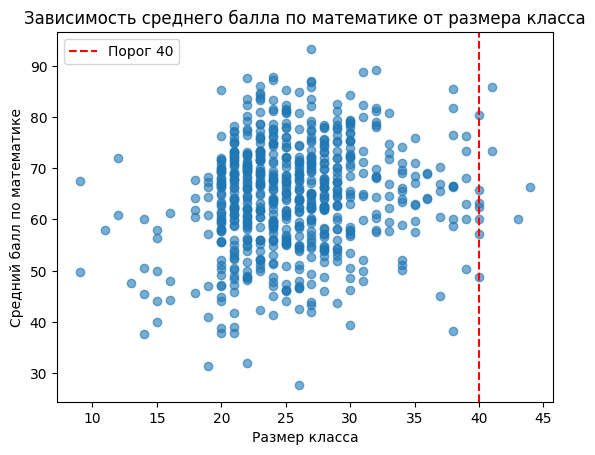

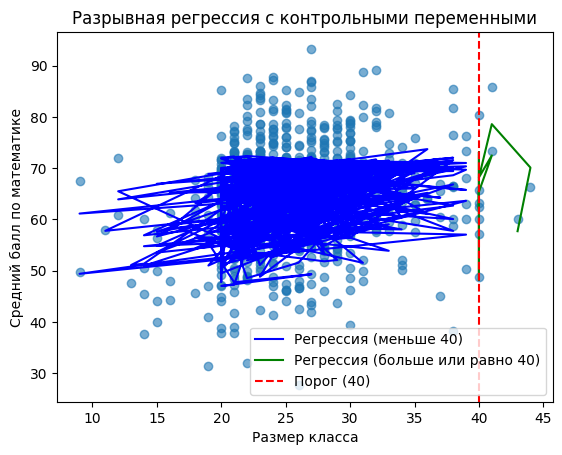

In [34]:
# Визуализация данных
plt.scatter(df_filtered['classize'], df_filtered['avgmath'], alpha=0.6)
plt.axvline(x=40, color='red', linestyle='--', label='Порог 40')
plt.title('Зависимость среднего балла по математике от размера класса')
plt.xlabel('Размер класса')
plt.ylabel('Средний балл по математике')
plt.legend()
plt.show()

# до порога
# ограничения на меньше 40
model_below = sm.OLS(y[df_filtered['classize'] < 40], X_with_controls[df_filtered['classize'] < 40]).fit()
predictions_below = model_below.predict(X_with_controls[df_filtered['classize'] < 40])

# после порога
# ограничения на больше 40 в нашей модели
model_above = sm.OLS(y[df_filtered['classize'] >= 40], X_with_controls[df_filtered['classize'] >= 40]).fit()
predictions_above = model_above.predict(X_with_controls[df_filtered['classize'] >= 40])

# Визуализация
plt.scatter(df_filtered['classize'], df_filtered['avgmath'], alpha=0.6)
plt.plot(df_filtered['classize'][df_filtered['classize'] < 40], predictions_below, color='blue', label='Регрессия (меньше 40)')
plt.plot(df_filtered['classize'][df_filtered['classize'] >= 40], predictions_above, color='green', label='Регрессия (больше или равно 40)')
plt.axvline(x=40, color='red', linestyle='--', label='Порог (40)')
plt.title('Разрывная регрессия с контрольными переменными')
plt.xlabel('Размер класса')
plt.ylabel('Средний балл по математике')
plt.legend()
plt.show()

Еще раз найдем модель для нашего пункта

пункт с)

In [35]:
# Sharp RDD
# влияние обучения в большом классе на результаты тестов
X_rdd = sm.add_constant(df_filtered[['large_cohort', 'classize', 'disadv', 'enrollment']])
model_rdd = sm.OLS(df_filtered['avgmath'], X_rdd).fit()
model_rdd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avgmath   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     82.09
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           4.71e-57
Time:                        11:28:02   Log-Likelihood:                -2493.6
No. Observations:                 699   AIC:                             4997.
Df Residuals:                     694   BIC:                             5020.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           68.8815      2.120     32.486      0.000      64.718      73.045
large_cohort     4.7644      1.497      3.183      0.002       1.826       7.703
classize         0.2192      0.071      3.090      0.002       0.080       0.358
disadv          -0.3319      0.020    -16.954      0.000      -0.370      -0.293
enrollment      -0.1467      0.060     -2.425      0.016      -0.265      -0.028
==============================================================================
Omnibus:                        3.038   Durbin-Watson:                   1.537
Prob(Omnibus):                  0.219   Jarque-Bera (JB):                3.005
Skew:                          -0.161   Prob(JB):                        0.223
Kurtosis:                       2.992   Cond. No.                         373.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
# вывод коэффициента при large_cohort и его интерпретация
effect_size = model_rdd.params['large_cohort']
effect_ci = model_rdd.conf_int().loc['large_cohort']

print(f"Оценка эффекта воздействия: {effect_size:.4f}")
print(f"ДИ: ({effect_ci[0]:.4f}, {effect_ci[1]:.4f})")


Оценка эффекта воздействия: 4.7644
ДИ: (1.8256, 7.7032)


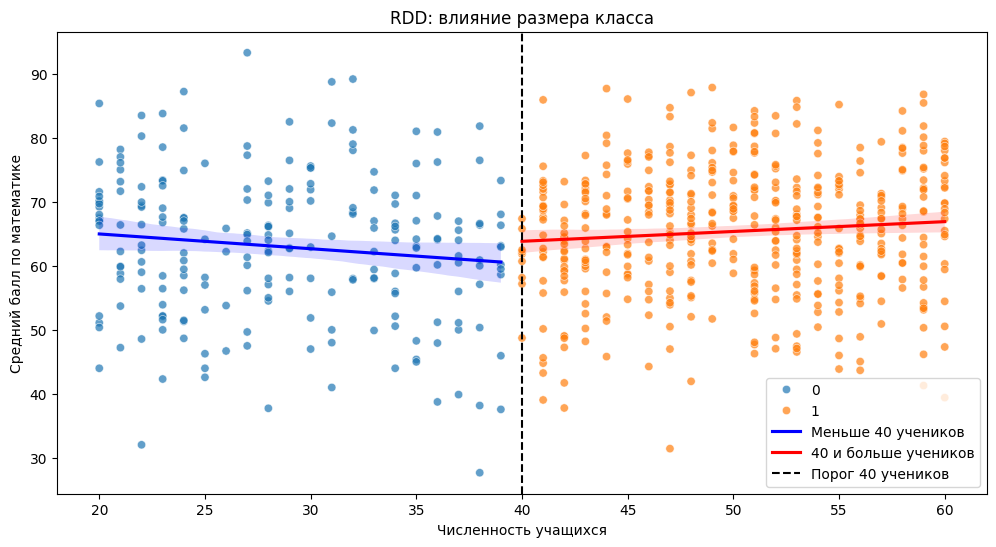

In [37]:
plt.figure(figsize=(12, 6))

# разбиваем данные на две группы:
# до порога (enrollment < 40) и после (enrollment >= 40)
df_left = df_filtered[df_filtered['enrollment'] < 40]
df_right = df_filtered[df_filtered['enrollment'] >= 40]
sns.scatterplot(x=df_filtered['enrollment'], y=df_filtered['avgmath'], hue=df_filtered['large_cohort'], alpha=0.7)

# строим регрессионные линии по обе стороны порога
sns.regplot(x=df_left['enrollment'], y=df_left['avgmath'], scatter=False, color='blue', label='Меньше 40 учеников')
sns.regplot(x=df_right['enrollment'], y=df_right['avgmath'], scatter=False, color='red', label='40 и больше учеников')

# линия разрыва порога
plt.axvline(x=40, linestyle='--', color='black', label='Порог 40 учеников')
plt.xlabel("Численность учащихся")
plt.ylabel("Средний балл по математике")
plt.title("RDD: влияние размера класса")
plt.legend()
plt.show()

пункт д)

In [38]:
# проверка чувствительности модели (исключение контрольных переменных)
X_rdd_no_controls = sm.add_constant(df_filtered[['large_cohort', 'classize']])
model_rdd_no_controls = sm.OLS(df_filtered['avgmath'], X_rdd_no_controls).fit()

model_rdd_no_controls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avgmath   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     13.33
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           2.09e-06
Time:                        11:28:04   Log-Likelihood:                -2615.8
No. Observations:                 699   AIC:                             5238.
Df Residuals:                     696   BIC:                             5251.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           54.6491      2.072     26.377      0.000      50.581      58.717
large_cohort     2.5500      0.831      3.069      0.002       0.919       4.181
classize         0.3230      0.076      4.266      0.000       0.174       0.472
==============================================================================
Omnibus:                        6.939   Durbin-Watson:                   1.407
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                6.954
Skew:                          -0.244   Prob(JB):                       0.0309
Kurtosis:                       3.011   Cond. No.                         141.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
coef5 = model_rdd_no_controls.params

eq5 = f"avgmath = {coef5[0]:.4f} + {coef5[1]:.4f} * large_cohort + {coef5[2]:.4f} * classize "
coef_df5 = pd.DataFrame(coef5, columns=['Coefficient'])
eq5

<ipython-input-39-423f8de51f1e>:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



'avgmath = 54.6491 + 2.5500 * large_cohort + 0.3230 * classize '

пункт е)

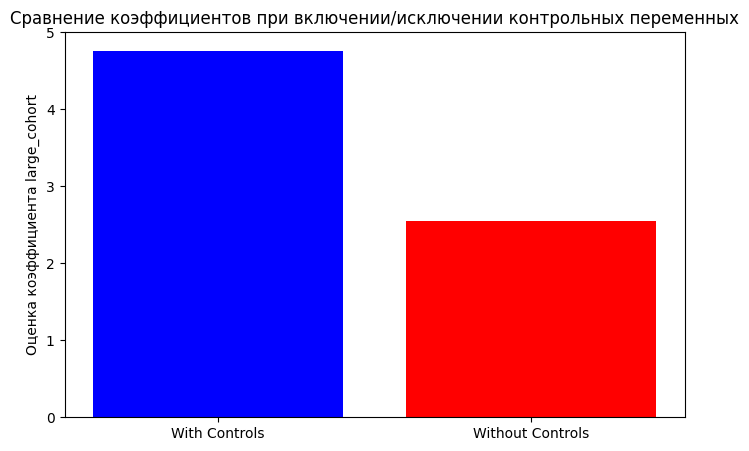

In [40]:
# визуализация чувствительности
coefficients = {
    'With Controls': model_rdd.params['large_cohort'],
    'Without Controls': model_rdd_no_controls.params['large_cohort']
}

plt.figure(figsize=(8, 5))
plt.bar(coefficients.keys(), coefficients.values(), color=['blue', 'red'])
plt.ylabel("Оценка коэффициента large_cohort")
plt.title("Сравнение коэффициентов при включении/исключении контрольных переменных")
plt.show()

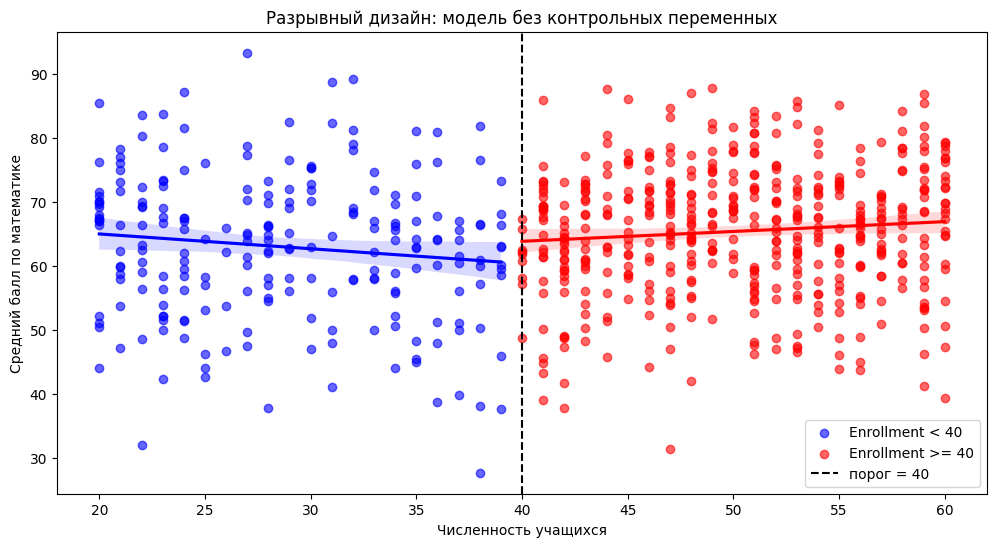

In [41]:
def plot_rdd_no_controls(data, x_var, y_var, threshold, title):
    plt.figure(figsize=(12, 6)) # определяем функцию и задаем размеры

    # разбиваем данные на группы до и после порогового значения
    below_threshold = data[data[x_var] < threshold]
    above_threshold = data[data[x_var] >= threshold]

    # отображаем точки на графике
    plt.scatter(below_threshold[x_var], below_threshold[y_var], color='blue', alpha=0.6, label=f'Enrollment < {threshold}')
    plt.scatter(above_threshold[x_var], above_threshold[y_var], color='red', alpha=0.6, label=f'Enrollment >= {threshold}')
    # тренды до и после порога
    sns.regplot(x=below_threshold[x_var], y=below_threshold[y_var], scatter=False, color='blue')
    sns.regplot(x=above_threshold[x_var], y=above_threshold[y_var], scatter=False, color='red')

    # добавление вертикальной линию в точке порога
    plt.axvline(x=threshold, linestyle='--', color='black', linewidth=1.5, label='порог = 40')
    plt.xlabel("Численность учащихся")
    plt.ylabel("Средний балл по математике")
    plt.title(title)
    plt.legend()
    plt.show()

# функция и результаты
plot_rdd_no_controls(df_filtered, 'enrollment', 'avgmath', 40, "Разрывный дизайн: модель без контрольных переменных")

пункт ф) добавление квадрата

In [42]:
# заменяем линейный тренд на квадратичный
X_rdd_quad = sm.add_constant(df_filtered[['large_cohort', 'classize', 'disadv', 'enrollment']])
X_rdd_quad['enrollment_2'] = df_filtered['enrollment']**2
model_rdd_quad = sm.OLS(df_filtered['avgmath'], X_rdd_quad).fit()
model_rdd_quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avgmath   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     67.95
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           8.62e-58
Time:                        11:28:06   Log-Likelihood:                -2489.5
No. Observations:                 699   AIC:                             4991.
Df Residuals:                     693   BIC:                             5018.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           80.7790      4.694     17.209      0.000      71.563      89.995
large_cohort     6.3771      1.594      4.001      0.000       3.247       9.507
classize         0.2541      0.072      3.547      0.000       0.113       0.395
disadv          -0.3297      0.019    -16.910      0.000      -0.368      -0.291
enrollment      -0.8249      0.246     -3.347      0.001      -1.309      -0.341
enrollment_2     0.0077      0.003      2.837      0.005       0.002       0.013
==============================================================================
Omnibus:                        2.572   Durbin-Watson:                   1.550
Prob(Omnibus):                  0.276   Jarque-Bera (JB):                2.513
Skew:                          -0.147   Prob(JB):                        0.285
Kurtosis:                       3.010   Cond. No.                     3.28e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
coef6 = model_rdd_quad.params

eq6 = f"avgmath = {coef6[0]:.4f} + {coef6[1]:.4f} * large_cohort + {coef6[2]:.4f} * classize  + {coef6[3]:.4f} * disadv + {coef6[4]:.4f} * enrollment + {coef6[5]:.4f} * enrollment_2"
coef_df6 = pd.DataFrame(coef5, columns=['Coefficient'])
eq6

<ipython-input-43-6ed3ac76ecc4>:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



'avgmath = 80.7790 + 6.3771 * large_cohort + 0.2541 * classize  + -0.3297 * disadv + -0.8249 * enrollment + 0.0077 * enrollment_2'

пункт g) введение плацебо-теста

In [44]:
# разрыв в проценте малообеспеченных учеников
# теперь зависимая переменная disadv
X_placebo = sm.add_constant(df_filtered[['large_cohort', 'classize', 'enrollment']])
X_placebo['enrollment_2'] = df_filtered['enrollment']**2
ml_placebo = sm.OLS(df_filtered['disadv'], X_placebo).fit()

ml_placebo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 disadv   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     6.236
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           6.22e-05
Time:                        11:28:06   Log-Likelihood:                -2955.9
No. Observations:                 699   AIC:                             5922.
Df Residuals:                     694   BIC:                             5944.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           28.9007      9.074      3.185      0.002      11.085      46.716
large_cohort    -1.6316      3.103     -0.526      0.599      -7.725       4.461
classize        -0.4982      0.138     -3.605      0.000      -0.770      -0.227
enrollment       0.3831      0.480      0.799      0.425      -0.559       1.325
enrollment_2    -0.0057      0.005     -1.075      0.283      -0.016       0.005
==============================================================================
Omnibus:                       45.580   Durbin-Watson:                   1.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.649
Skew:                           0.613   Prob(JB):                     2.73e-11
Kurtosis:                       2.589   Cond. No.                     3.26e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
coef7 = ml_placebo.params

eq7 = f"disadv = {coef7[0]:.4f} + {coef7[1]:.4f} * large_cohort + {coef7[2]:.4f} * classize   + {coef7[3]:.4f} * enrollment + {coef7[4]:.4f} * enrollment_2"
coef_df7 = pd.DataFrame(coef7, columns=['Coefficient'])
eq7

<ipython-input-45-63d8943a9f2a>:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



'disadv = 28.9007 + -1.6316 * large_cohort + -0.4982 * classize   + 0.3831 * enrollment + -0.0057 * enrollment_2'

<ipython-input-46-4ab0586f3663>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



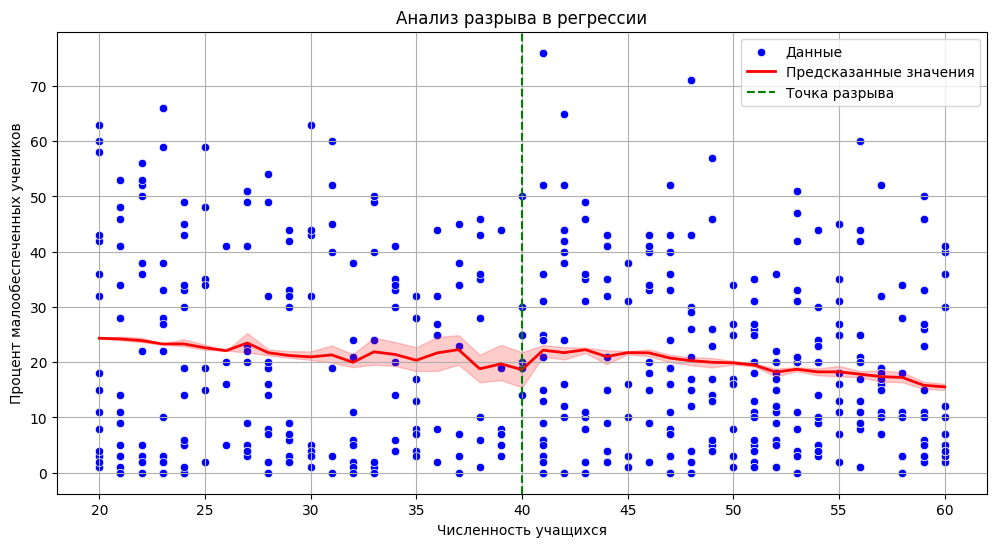

In [46]:
df_filtered['predicted_disadv'] = ml_placebo.predict(X_placebo)
# предсказанные значения от нашей модели

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_filtered, x='enrollment', y='disadv', color='blue', label='Данные')
sns.lineplot(data=df_filtered, x='enrollment', y='predicted_disadv', color='red', label='Предсказанные значения', linewidth=2)

# добавляем вертикальную линию в точке разрыва
plt.axvline(x=40, color='green', linestyle='--', label='Точка разрыва')

plt.title('Анализ разрыва в регрессии')
plt.xlabel('Численность учащихся')
plt.ylabel('Процент малообеспеченных учеников')
plt.legend()
plt.grid()
plt.show()

выше анализ разрыва регрессии по точка, а тут проведем одну линию тренда для более типичного анализа РДД

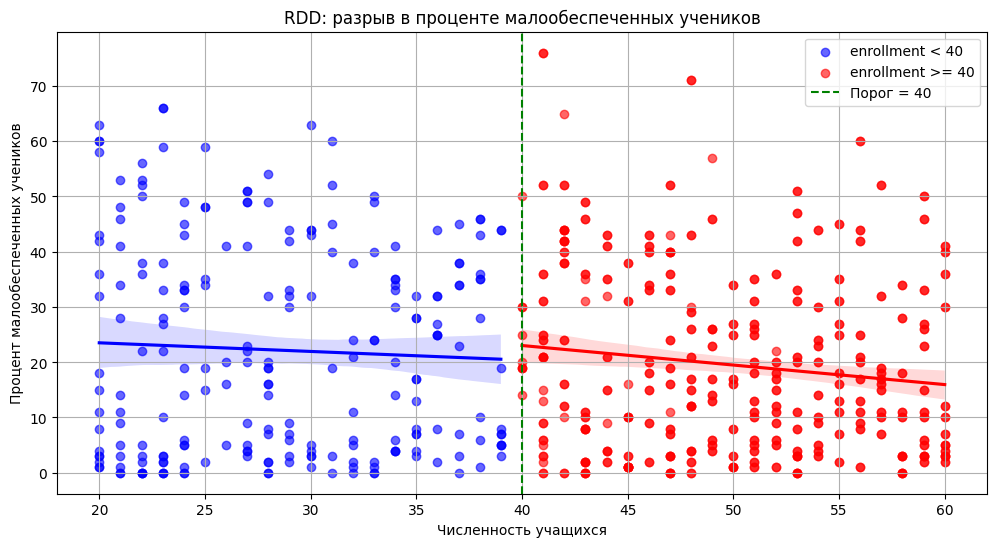

In [47]:
# пишем функцию, чтобы визуализировать
def plot_rdd_disadv(data, x_var, y_var, threshold, title):
    plt.figure(figsize=(12, 6))
    # делим на группы до и после порога 40
    below_threshold = data[data[x_var] < threshold]
    above_threshold = data[data[x_var] >= threshold]

    # точки на графике
    plt.scatter(below_threshold[x_var], below_threshold[y_var], color='blue', alpha=0.6, label=f'{x_var} < {threshold}')
    plt.scatter(above_threshold[x_var], above_threshold[y_var], color='red', alpha=0.6, label=f'{x_var} >= {threshold}')
    # регрессионные тренды слева и справа
    sns.regplot(x=below_threshold[x_var], y=below_threshold[y_var], scatter=False, color='blue')
    sns.regplot(x=above_threshold[x_var], y=above_threshold[y_var], scatter=False, color='red')

    # аналогично пунктам выше здесь разрыв
    plt.axvline(x=threshold, linestyle='--', color='green', linewidth=1.5, label=f'Порог = {threshold}')

    plt.xlabel("Численность учащихся")
    plt.ylabel("Процент малообеспеченных учеников")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# модель регрессии для предсказанных значений
formula = "disadv ~ enrollment + I(enrollment >= 40)"
ml_placebo = ols(formula, data=df_filtered).fit()

plot_rdd_disadv(df_filtered, 'enrollment', 'disadv', 40, "RDD: разрыв в проценте малообеспеченных учеников")


пункт h) по образу семинара с 2МНК

In [48]:
df_filtered["above_cutoff"] = (df_filtered["enrollment"] >= 40).astype(int)

# нормируем относительно значения порога
df_filtered["enrollment_c"] = df_filtered["enrollment"] - 40
df_filtered["enrollment_c2"] = df_filtered["enrollment_c"] ** 2  # квадрат оставили

# 1: предсказываем large_cohort через инструмент
exog_first_stage = sm.add_constant(df_filtered[["enrollment_c", "enrollment_c2", "above_cutoff"]])
dependent_first_stage = df_filtered["large_cohort"]

# 1: OLS регрессия для large_cohort
iv_11 = IV2SLS(dependent=dependent_first_stage,
               exog=exog_first_stage,
               endog=None,
               instruments=None).fit()

iv_11.summary

<ipython-input-48-a34682897ebd>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-48-a34682897ebd>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-48-a34682897ebd>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<class 'linearmodels.compat.statsmodels.Summary'>
"""
                            OLS Estimation Summary                            
==============================================================================
Dep. Variable:           large_cohort   R-squared:                      1.0000
Estimator:                        OLS   Adj. R-squared:                 1.0000
No. Observations:                 699   F-statistic:                 3.473e+31
Date:                Sun, Mar 16 2025   P-value (F-stat)                0.0000
Time:                        11:28:11   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                               
=================================================================================
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
const          8.882e-16  2.668e-16     3.3295     0.0009   3.653e-16   1.411e-15
enrollment_c  -1.665e-16  1.846e-17    -9.0210     0.0000  -2.027e-16  -1.304e-16
enrollment_c2  8.674e-19  8.771e-19     0.9889     0.3227  -8.517e-19   2.586e-18
above_cutoff      1.0000  3.663e-16   2.73e+15     0.0000      1.0000      1.0000
=================================================================================
"""

In [49]:
#добавление предсказанных значений large_cohort_hat
df_filtered["large_cohort_hat"] = dependent_first_stage - iv_1.resids

# 2 IV-регрессия с логарифмом результата avgmath
exog_second_stage = sm.add_constant(df_filtered[["large_cohort_hat", "enrollment_c", "enrollment_c2"]])
dependent_second_stage = np.log(df_filtered["avgmath"])  # логарифмируем зависимую переменную

# 2 этап
iv_22 = IV2SLS(dependent=dependent_second_stage,
               exog=exog_second_stage,
               endog=None,
               instruments=None).fit()

iv_22.summary

<ipython-input-49-cd48dfb56c4d>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.11/dist-packages/linearmodels/iv/model.py:557: MissingValueWarning:


Inputs contain missing values. Dropping rows with missing observations.



<class 'linearmodels.compat.statsmodels.Summary'>
"""
                            OLS Estimation Summary                            
==============================================================================
Dep. Variable:                avgmath   R-squared:                      0.0271
Estimator:                        OLS   Adj. R-squared:                 0.0207
No. Observations:                 462   F-statistic:                    13.442
Date:                Sun, Mar 16 2025   P-value (F-stat)                0.0038
Time:                        11:28:11   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                 
====================================================================================
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
const                4.1313     0.0132     313.61     0.0000      4.1055      4.1571
large_cohort_hat     0.0019     0.0012     1.5099     0.1311     -0.0006      0.0043
enrollment_c         0.0015     0.0007     2.2440     0.0248      0.0002      0.0028
enrollment_c2        0.0001  6.217e-05     2.1409     0.0323   1.125e-05      0.0003
====================================================================================
"""

In [50]:
coef8 = iv_22.params

eq8 = f"avgmath = {coef8[0]:.4f} + {coef8[1]:.4f} * large_cohort_hat + {coef8[2]:.4f} * enrollment_c   + {coef8[3]:.4f} * enrollment_c2 "
coef_df8 = pd.DataFrame(coef8, columns=['Coefficient'])
eq8

<ipython-input-50-68111be08f79>:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



'avgmath = 4.1313 + 0.0019 * large_cohort_hat + 0.0015 * enrollment_c   + 0.0001 * enrollment_c2 '

<ipython-input-51-8545df33812c>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



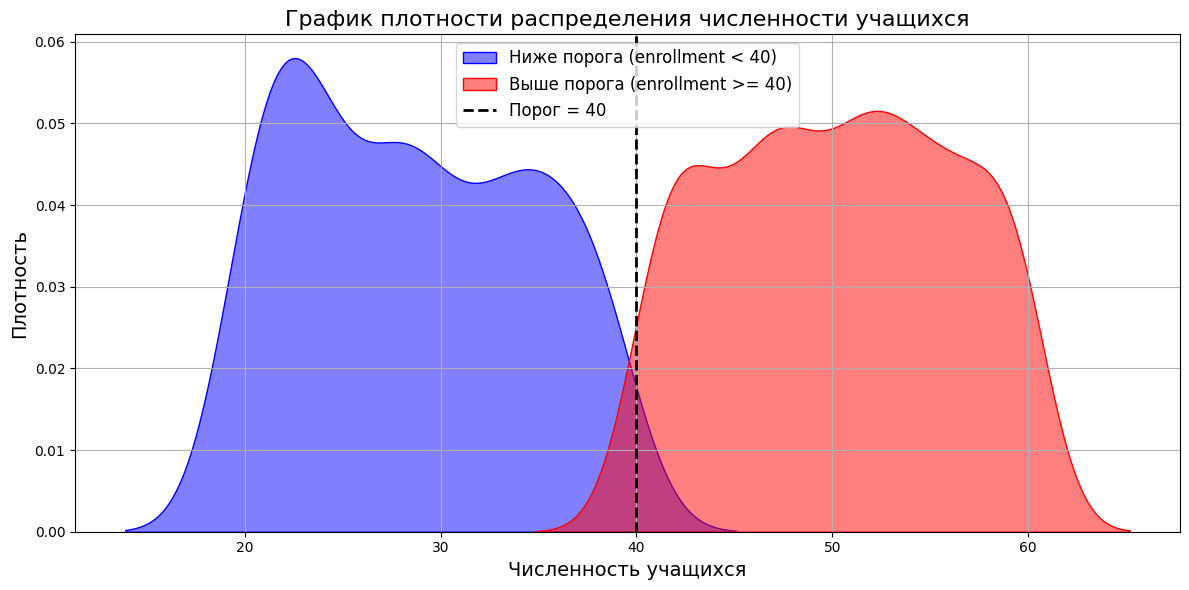

In [51]:
df_filtered["above_cutoff"] = (df_filtered["enrollment"] >= 40).astype(int)

# для интереса график плотности
plt.figure(figsize=(12, 6))
sns.kdeplot(df_filtered[df_filtered["above_cutoff"] == 0]["enrollment"],
             color='blue', label='Ниже порога (enrollment < 40)', fill=True, alpha=0.5)

# график для данных выше порога, формула из интернета
sns.kdeplot(df_filtered[df_filtered["above_cutoff"] == 1]["enrollment"],
             color='red', label='Выше порога (enrollment >= 40)', fill=True, alpha=0.5)
plt.axvline(x=40, linestyle='--', color='black', linewidth=2, label='Порог = 40')

# настройка графика
plt.xlabel("Численность учащихся", fontsize=14)
plt.ylabel("Плотность", fontsize=14)
plt.title("График плотности распределения численности учащихся", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()